In [78]:
from dotenv import load_dotenv
import os
import logging
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import logging
import seaborn as sns

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load environment variables
load_dotenv()

True

In [79]:
output_file = os.getenv('OUTPUT_FILE')
file_path = output_file
data = pd.read_csv(file_path)

# Step 1: Rename columns to provide meaningful names
# Manually assign new column names based on their observed contents
columns = [
    "Group",
    "Age",
    "MoCA",
    "UPDRS_III",
    "Hor_Anti_Latency",
    "Hor_Anti_Error",
    "Ver_Anti_Latency",
    "Ver_Anti_Error",
    "Hor_Pro_Right_Latency",
    "Hor_Pro_Right_Speed",
    "Hor_Pro_Right_MaxSpeed",
    "Hor_Pro_Right_Gain",
    "Hor_Pro_Left_Latency",
    "Hor_Pro_Left_Speed",
    "Hor_Pro_Left_MaxSpeed",
    "Hor_Pro_Left_Gain",
    "Ver_Pro_Up_Latency",
    "Ver_Pro_Up_Speed",
    "Ver_Pro_Up_MaxSpeed",
    "Ver_Pro_Up_Gain",
    "Ver_Pro_Down_Latency",
    "Ver_Pro_Down_Speed",
    "Ver_Pro_Down_MaxSpeed",
    "Ver_Pro_Down_Gain",
]

# Assign cleaned column names, dropping unnecessary unnamed columns
data.columns = columns[:data.shape[1]]

# Step 2: Drop unnecessary rows that don't contain data
# Remove rows that are placeholders or headers
data_cleaned = data.dropna(subset=["Age"]).copy()

# Step 3: Convert numeric columns to proper data types
numeric_columns = data_cleaned.columns[1:]  # All columns except 'Group'
data_cleaned[numeric_columns] = data_cleaned[numeric_columns].apply(pd.to_numeric, errors="coerce")

# Step 4: Reset index for cleaner data
data_cleaned.reset_index(drop=True, inplace=True)

data_cleaned = data_cleaned.drop(index=[0, 1])

# Checking the full shape of the cleaned data to confirm the number of rows and if there are unexpected drops
data_cleaned.shape


(98, 24)

In [80]:
data_cleaned.head()

,Group,Age,MoCA,UPDRS_III,Hor_Anti_Latency,Hor_Anti_Error,Ver_Anti_Latency,Ver_Anti_Error,Hor_Pro_Right_Latency,Hor_Pro_Right_Speed,...,Hor_Pro_Left_MaxSpeed,Hor_Pro_Left_Gain,Ver_Pro_Up_Latency,Ver_Pro_Up_Speed,Ver_Pro_Up_MaxSpeed,Ver_Pro_Up_Gain,Ver_Pro_Down_Latency,Ver_Pro_Down_Speed,Ver_Pro_Down_MaxSpeed,Ver_Pro_Down_Gain
2,PD1,58.49,24.0,40.0,329.781250,3.125000,392.000000,33.333333,269.900000,284.034000,...,454.192500,0.892500,290.000000,139.637500,506.936000,1.006875,277.062500,56.678125,197.205625,1.010000
3,PD2,72.79,30.0,18.0,264.290323,64.516129,249.814815,70.370370,185.416667,235.810833,...,359.972727,0.840909,189.615385,200.039333,482.352857,1.022000,249.733333,179.216667,403.485333,1.130667
4,PD3,71.18,20.0,52.0,218.900000,51.612903,278.344828,48.275862,167.000000,205.985000,...,351.744000,0.679000,198.857143,85.872857,221.724286,0.785000,204.000000,103.774667,264.893333,0.698000
5,PD4,60.80,28.0,24.0,295.222222,55.555556,310.571429,71.428571,209.900000,242.385000,...,511.176250,0.831250,272.461538,102.453077,260.980000,0.733846,237.785714,70.583571,206.768571,0.971429
6,PD5,59.61,26.0,22.0,157.161290,96.774194,183.700000,93.548387,157.700000,232.112500,...,417.408333,0.863333,164.500000,194.479000,435.523750,0.796000,172.000000,227.960000,478.098000,0.996667


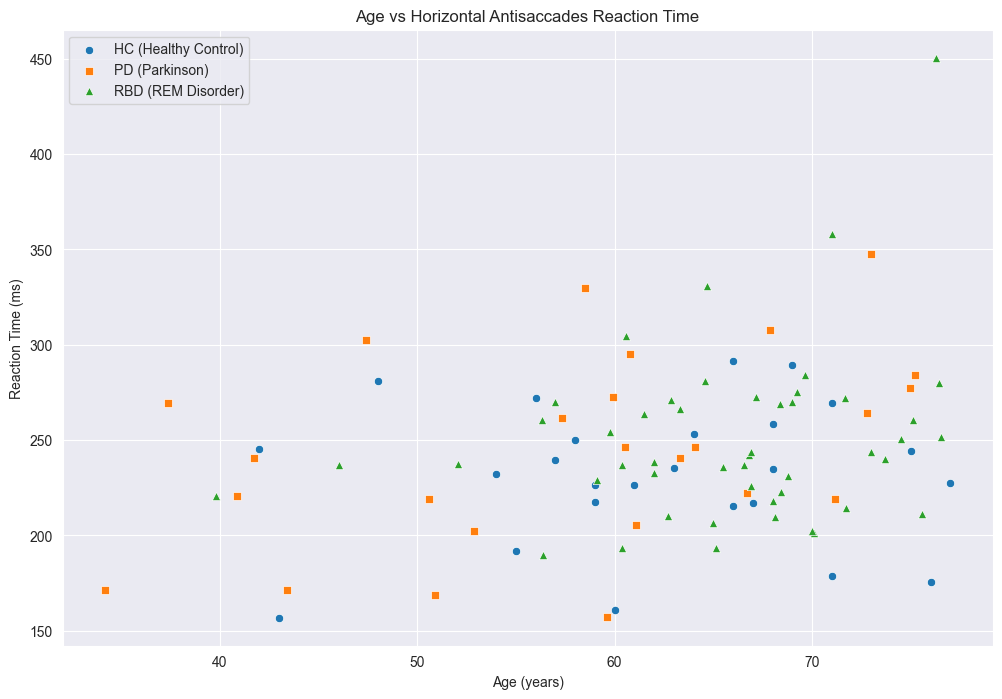

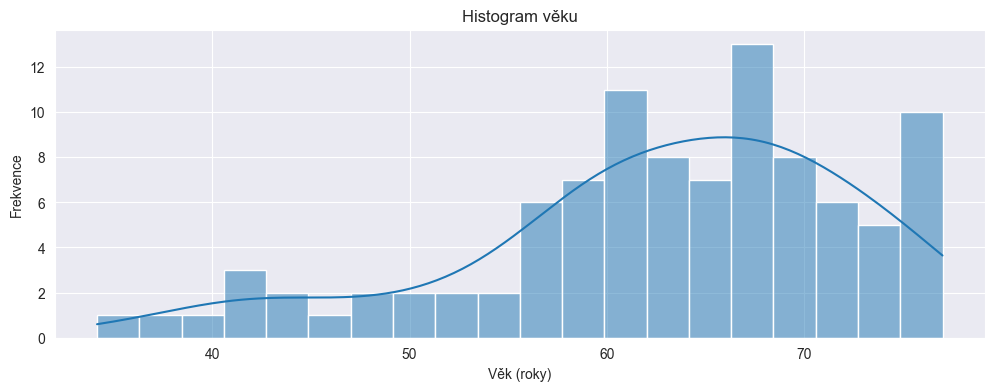

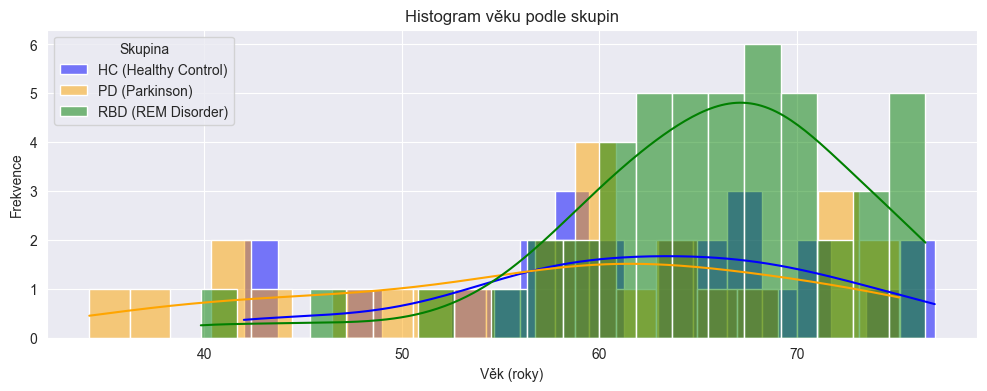

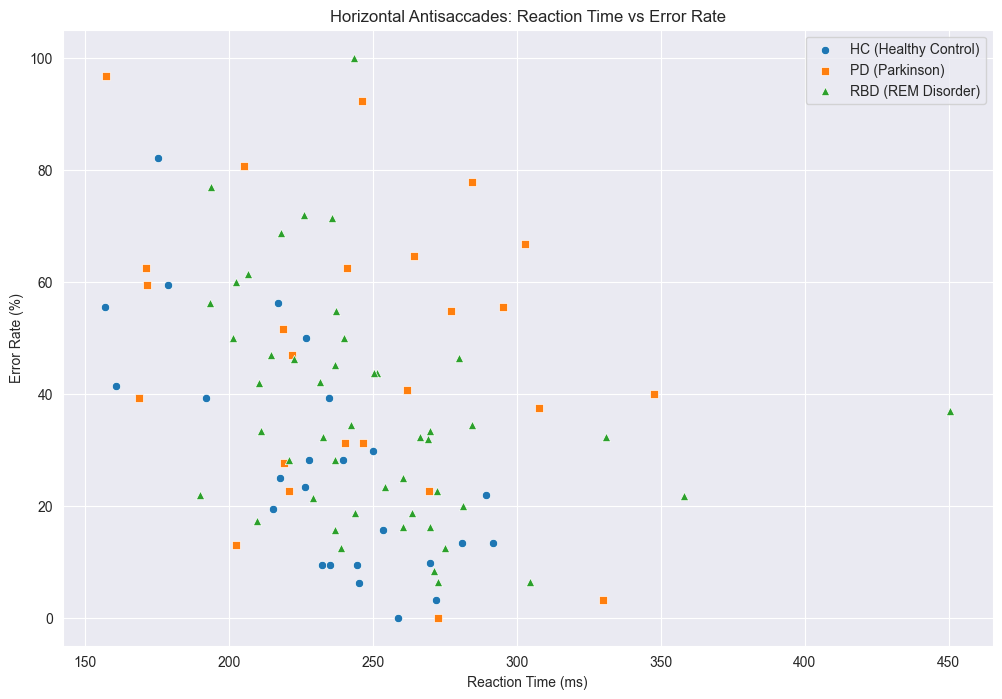

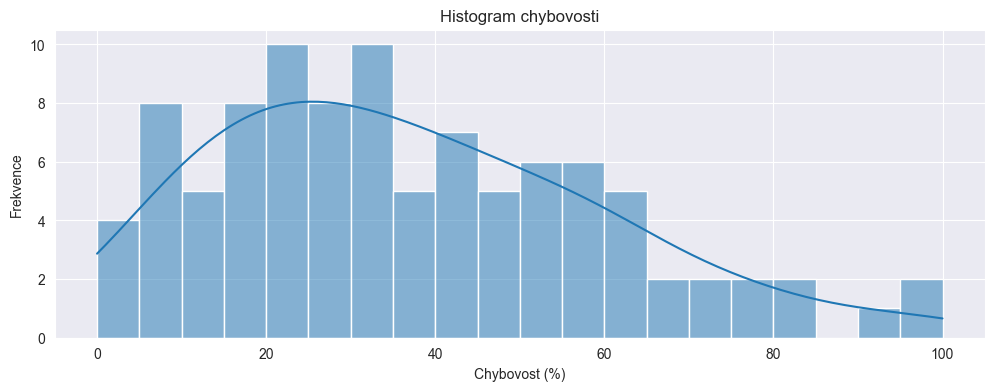

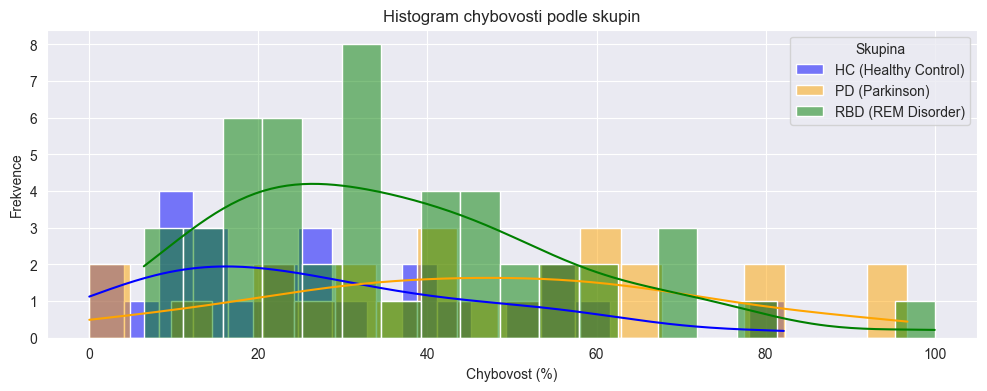

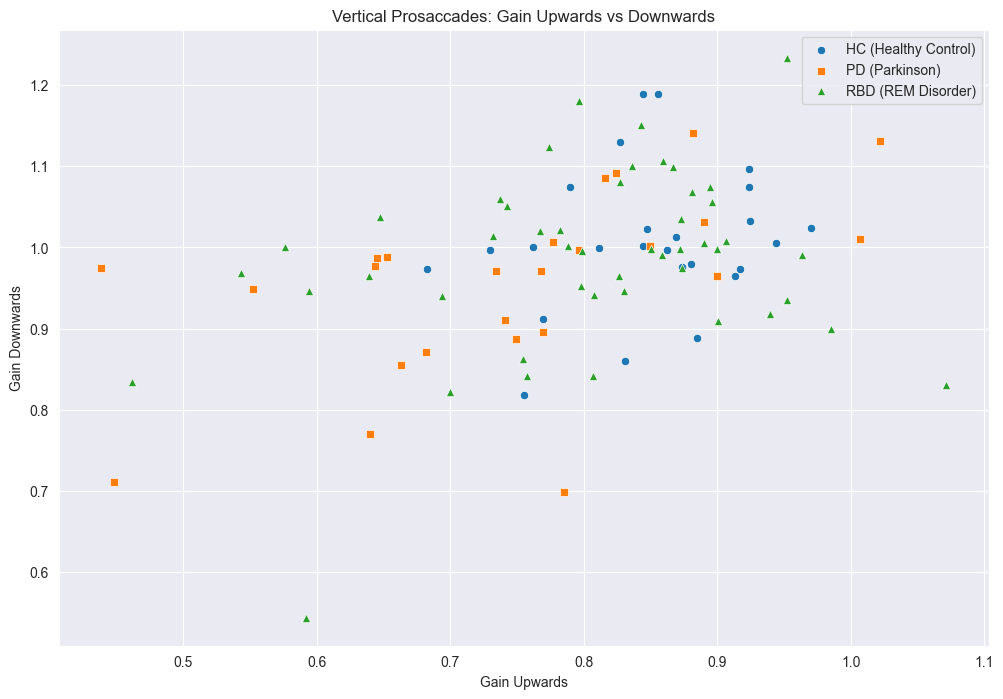

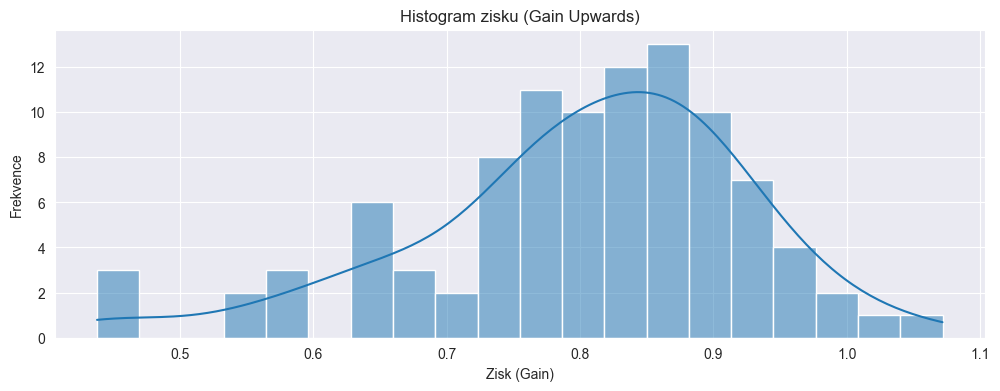

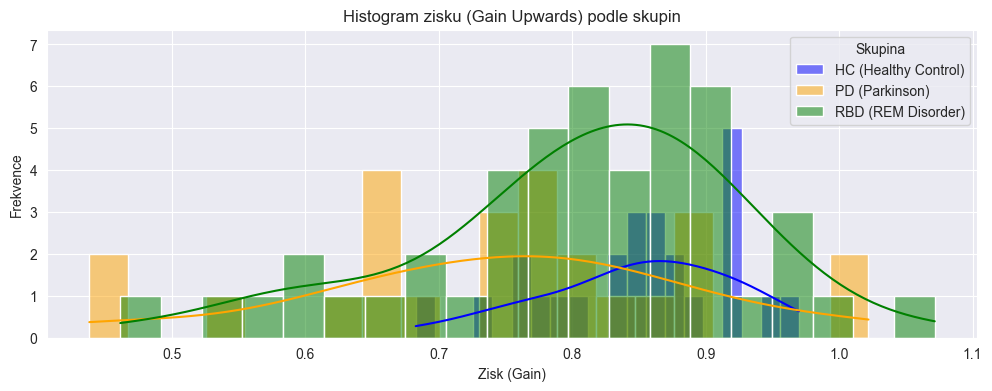

In [81]:
# Separate the groups
groups = data_cleaned['Group'].unique()

# Filter data into respective groups
hc_data = data_cleaned[data_cleaned['Group'].str.contains("HC", na=False)]
pd_data = data_cleaned[data_cleaned['Group'].str.contains("PD", na=False)]
rbd_data = data_cleaned[data_cleaned['Group'].str.contains("RBD", na=False)]



# Visualization: Scatterplot for Age vs Reaction Time (Horizontal Antisaccades)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=hc_data['Age'], y=hc_data['Hor_Anti_Latency'], label='HC (Healthy Control)', marker='o')
sns.scatterplot(x=pd_data['Age'], y=pd_data['Hor_Anti_Latency'], label='PD (Parkinson)', marker='s')
sns.scatterplot(x=rbd_data['Age'], y=rbd_data['Hor_Anti_Latency'], label='RBD (REM Disorder)', marker='^')
plt.title('Age vs Horizontal Antisaccades Reaction Time')
plt.xlabel('Age (years)')
plt.ylabel('Reaction Time (ms)')
plt.legend()
plt.show()


# Přidání histogramu pro věk
plt.figure(figsize=(12, 4))
sns.histplot(data_cleaned['Age'], bins=20, kde=True)
plt.title('Histogram věku')
plt.xlabel('Věk (roky)')
plt.ylabel('Frekvence')
plt.show()

# Přidání histogramu pro věk pro jednotlivé skupiny
plt.figure(figsize=(12, 4))
sns.histplot(hc_data['Age'], bins=20, kde=True, color='blue', label='HC (Healthy Control)', alpha=0.5)
sns.histplot(pd_data['Age'], bins=20, kde=True, color='orange', label='PD (Parkinson)', alpha=0.5)
sns.histplot(rbd_data['Age'], bins=20, kde=True, color='green', label='RBD (REM Disorder)', alpha=0.5)
plt.title('Histogram věku podle skupin')
plt.xlabel('Věk (roky)')
plt.ylabel('Frekvence')
plt.legend(title='Skupina')
plt.show()

# Visualization: Reaction Time vs Error Rate (Horizontal Antisaccades)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=hc_data['Hor_Anti_Latency'], y=hc_data['Hor_Anti_Error'], label='HC (Healthy Control)', marker='o')
sns.scatterplot(x=pd_data['Hor_Anti_Latency'], y=pd_data['Hor_Anti_Error'], label='PD (Parkinson)', marker='s')
sns.scatterplot(x=rbd_data['Hor_Anti_Latency'], y=rbd_data['Hor_Anti_Error'], label='RBD (REM Disorder)', marker='^')
plt.title('Horizontal Antisaccades: Reaction Time vs Error Rate')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.show()

# Přidání histogramu pro chybovost
plt.figure(figsize=(12, 4))
sns.histplot(data_cleaned['Hor_Anti_Error'], bins=20, kde=True)
plt.title('Histogram chybovosti')
plt.xlabel('Chybovost (%)')
plt.ylabel('Frekvence')
plt.show()

# Přidání histogramu pro chybovost pro jednotlivé skupiny
plt.figure(figsize=(12, 4))
sns.histplot(hc_data['Hor_Anti_Error'], bins=20, kde=True, color='blue', label='HC (Healthy Control)', alpha=0.5)
sns.histplot(pd_data['Hor_Anti_Error'], bins=20, kde=True, color='orange', label='PD (Parkinson)', alpha=0.5)
sns.histplot(rbd_data['Hor_Anti_Error'], bins=20, kde=True, color='green', label='RBD (REM Disorder)', alpha=0.5)
plt.title('Histogram chybovosti podle skupin')
plt.xlabel('Chybovost (%)')
plt.ylabel('Frekvence')
plt.legend(title='Skupina')
plt.show()

# Visualization: Vertical Prosaccades Gain (Upwards vs Downwards)
plt.figure(figsize=(12, 8))
sns.scatterplot(x=hc_data['Ver_Pro_Up_Gain'], y=hc_data['Ver_Pro_Down_Gain'], label='HC (Healthy Control)', marker='o')
sns.scatterplot(x=pd_data['Ver_Pro_Up_Gain'], y=pd_data['Ver_Pro_Down_Gain'], label='PD (Parkinson)', marker='s')
sns.scatterplot(x=rbd_data['Ver_Pro_Up_Gain'], y=rbd_data['Ver_Pro_Down_Gain'], label='RBD (REM Disorder)', marker='^')
plt.title('Vertical Prosaccades: Gain Upwards vs Downwards')
plt.xlabel('Gain Upwards')
plt.ylabel('Gain Downwards')
plt.legend()
plt.show()



# Přidání histogramu pro zisk
plt.figure(figsize=(12, 4))
sns.histplot(data_cleaned['Ver_Pro_Up_Gain'], bins=20, kde=True)
plt.title('Histogram zisku (Gain Upwards)')
plt.xlabel('Zisk (Gain)')
plt.ylabel('Frekvence')
plt.show()



# Přidání histogramu pro zisk pro jednotlivé skupiny
plt.figure(figsize=(12, 4))
sns.histplot(hc_data['Ver_Pro_Up_Gain'], bins=20, kde=True, color='blue', label='HC (Healthy Control)', alpha=0.5)
sns.histplot(pd_data['Ver_Pro_Up_Gain'], bins=20, kde=True, color='orange', label='PD (Parkinson)', alpha=0.5)
sns.histplot(rbd_data['Ver_Pro_Up_Gain'], bins=20, kde=True, color='green', label='RBD (REM Disorder)', alpha=0.5)
plt.title('Histogram zisku (Gain Upwards) podle skupin')
plt.xlabel('Zisk (Gain)')
plt.ylabel('Frekvence')
plt.legend(title='Skupina')
plt.show()

# ... existující kód ...

## 3 hypo

In [82]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Zkontrolujte unikátní hodnoty v každé skupině
print(data_cleaned.groupby('Group')['Hor_Anti_Latency'].unique())

Group
HC1                  [227.66]
HC10                [291.665]
HC11                [253.345]
HC12                [235.125]
HC13                [226.635]
                 ...         
RBD85    [330.93333333333334]
RBD87    [269.80645161290323]
RBD90              [214.4375]
RBD91     [263.5483870967742]
RBD96    [220.67741935483872]
Name: Hor_Anti_Latency, Length: 98, dtype: object


In [83]:
# Zjistěte počet pozorování v každé skupině
print(data_cleaned['Group'].value_counts())

Group
PD1      1
HC10     1
RBD25    1
RBD90    1
RBD3     1
        ..
RBD41    1
RBD20    1
RBD32    1
RBD17    1
HC13     1
Name: count, Length: 98, dtype: int64


In [84]:
# Zkontrolujte datové typy
print(data_cleaned.dtypes)

Group                      object
Age                       float64
MoCA                      float64
UPDRS_III                 float64
Hor_Anti_Latency          float64
Hor_Anti_Error            float64
Ver_Anti_Latency          float64
Ver_Anti_Error            float64
Hor_Pro_Right_Latency     float64
Hor_Pro_Right_Speed       float64
Hor_Pro_Right_MaxSpeed    float64
Hor_Pro_Right_Gain        float64
Hor_Pro_Left_Latency      float64
Hor_Pro_Left_Speed        float64
Hor_Pro_Left_MaxSpeed     float64
Hor_Pro_Left_Gain         float64
Ver_Pro_Up_Latency        float64
Ver_Pro_Up_Speed          float64
Ver_Pro_Up_MaxSpeed       float64
Ver_Pro_Up_Gain           float64
Ver_Pro_Down_Latency      float64
Ver_Pro_Down_Speed        float64
Ver_Pro_Down_MaxSpeed     float64
Ver_Pro_Down_Gain         float64
dtype: object


In [85]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Vytvoření modelu ANOVA
model = ols('Hor_Anti_Latency ~ Group', data=data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Výstup výsledků ANOVA
print(anova_table)

/Users/barbora/Desktop/Skola/ING/1/AEDA/semestralka/.venv/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal